# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import math
import seaborn as sns

# Loading CSV

In [2]:
dataset = pd.read_csv('../results/Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz/Intersect_masterset.csv')
dataset.head()

,range,n1,average1,std1,n2,average2,std2,skewed_1,skewed_2,non_skewed,fastest_algo
0,65518,9862,16767.2,21066.0,9862,16767.2,21066.0,307,302,8820,skewed_2
1,65518,9862,16767.2,21066.0,10,20967.0,22080.1,270,114,73,non_skewed
2,65518,9862,16767.2,21066.0,4,21096.2,24358.7,258,52,71,skewed_2
3,65518,9862,16767.2,21066.0,48,22803.3,22462.6,337,119,183,skewed_2
4,65518,9862,16767.2,21066.0,3131,17175.5,21213.4,392,254,1046,skewed_2


# Building Dataset

In [3]:
feature_cols = ['n1', 'n2', 'range']
algos = ['skewed_1', 'skewed_2', 'non_skewed']

In [4]:
def get_X(d): 
    return d.loc[:, feature_cols].values

In [5]:
get_X(dataset).shape

(640000, 3)

In [6]:
def get_ys(d):
    return d.loc[:, algos].values

In [7]:
get_ys(dataset).shape

(640000, 3)

In [8]:
def get_cy(d):
    return np.array(d.loc[:, 'fastest_algo'].values)

In [9]:
get_cy(dataset).shape

(640000,)

In [10]:
def get_cyTimes(d):
    return np.array([min(a) for a in get_ys(d)])

In [11]:
get_cyTimes(dataset).shape

(640000,)

In [12]:
def get_gain_dataset(d):
    d2 = d.assign(gain=[float(max(a)) / max(1,min(a)) for a in get_ys(d)]) 
    d2 = d2[d2.gain > 2]
    reps = [int(math.log(x, 2)) for x in d2.gain]
    d2 = d2.loc[np.repeat(d2.index.values, reps)]
    d2 = d2.sort_values(by=['gain'], ascending=False)
    return d2

In [13]:
gain_dataset = get_gain_dataset(dataset)
gain_dataset.head()

,range,n1,average1,std1,n2,average2,std2,skewed_1,skewed_2,non_skewed,fastest_algo,gain
375048,65535,530445,16886.4,21253.8,250780,19328.8,21691.7,185,28278,361320,skewed_1,1953.081081
375048,65535,530445,16886.4,21253.8,250780,19328.8,21691.7,185,28278,361320,skewed_1,1953.081081
375048,65535,530445,16886.4,21253.8,250780,19328.8,21691.7,185,28278,361320,skewed_1,1953.081081
375048,65535,530445,16886.4,21253.8,250780,19328.8,21691.7,185,28278,361320,skewed_1,1953.081081
375048,65535,530445,16886.4,21253.8,250780,19328.8,21691.7,185,28278,361320,skewed_1,1953.081081


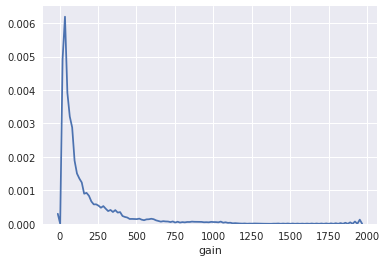

In [14]:
from scipy.stats import norm
sns.set();
sns.distplot(gain_dataset.gain, hist=False)

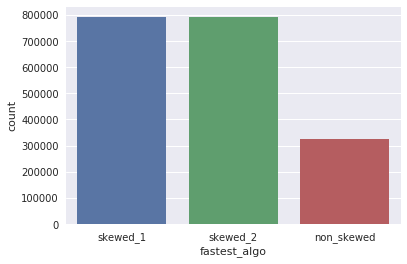

In [15]:
sns.set(color_codes=True)
sns.countplot(x="fastest_algo", data=gain_dataset)

In [16]:
def normalize_dataset(d):
    val_count = d["fastest_algo"].value_counts().tolist()
    min_count = min(val_count)
    d = pd.concat([d[d.fastest_algo == algo].head(min_count) for algo in algos])
    return d

In [17]:
normed_dataset = normalize_dataset(get_gain_dataset(dataset))
normed_dataset.shape

(977169, 12)

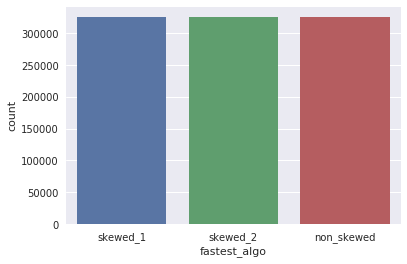

In [18]:
sns.set(color_codes=True)
sns.countplot(x="fastest_algo", data=normed_dataset)

In [19]:
def get_benchmark_set(d, is_test=False):
    if(not is_test):
        d = get_gain_dataset(d)
        d = normalize_dataset(d)
    benchmarkSet = get_X(d).tolist()
    ys = get_ys(d)
    cyTimes = get_cyTimes(d)
    cy = get_cy(d)
    for index, attributes in enumerate(benchmarkSet):
        for time in ys[index]:
            attributes.append(time)
        attributes.append(cyTimes[index])
        attributes.append(cy[index])
    return np.array(benchmarkSet)

In [20]:
#get_benchmark_set(dataset).shape

# Calculating value of the project

In [21]:
def percentChange(new, old):
    return ((float(old)/new)-1)

In [22]:
def getAlgoTime(algoName, row):
    for index, algo in enumerate(algos):
        if(algoName == algo):
            return int(row[len(feature_cols) + index])
    print('oups none of the available algos')

In [23]:
def getOldSchoolAlgo(n1, n2):
    threshold = 64
    n1 = float(n1)
    n2 = float(n2)
    if (n1 * threshold < n2):
        return 'skewed_1'
    if (n2 * threshold < n1):
        return 'skewed_2'
    return 'non_skewed'

In [24]:
def calculateValueOfML(train, test):
    #clf = DecisionTreeClassifier(max_depth=None, random_state=0)
    from sklearn.linear_model import SGDClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    #import xgboost as xgb
    from xgboost import XGBClassifier
    
    #clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, random_state=0)
    clf = XGBClassifier(n_estimators=100, learning_rate=1, n_jobs=-1)
    clf.fit(train[:, 0:len(feature_cols)], train[:,-1])
    
    mlChosenAlgos = clf.predict(test[:, 0:len(feature_cols)])

    GoodPredictionsCount = 0
    mlTotTime = 0
    osTotTime = 0
    perfectTotTime = 0
    for i, algo in enumerate(mlChosenAlgos):
        if(algo == test[i,-1]):
            GoodPredictionsCount += 1
        mlTotTime += getAlgoTime(algo, test[i])
        n1 = test[i,feature_cols.index('n1')]
        n2 = test[i,feature_cols.index('n2')]
        osAlgo = getOldSchoolAlgo(n1 , n2)
        osTotTime += getAlgoTime(osAlgo, test[i])
        perfectTotTime += int(test[i,-2])

    print("Average classification precision: %.2f" % (float(GoodPredictionsCount)/len(mlChosenAlgos)))
    print("Total ml time: %d" % mlTotTime)
    print("Total old school time: %d" % osTotTime)
    print("Machine learning is faster by : %.2f" % percentChange(mlTotTime, osTotTime))
    print("With perfect prediction : %.2f" % percentChange(perfectTotTime, osTotTime))

In [25]:
benchmarkSet = get_benchmark_set(dataset)
print(benchmarkSet.shape)

(977169, 8)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(benchmarkSet, benchmarkSet, test_size=0.2, random_state=0)
calculateValueOfML(X_train, X_test)

/home/jeremie/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Average classification precision: 0.98
Total ml time: 65520016
Total old school time: 4940844501
Machine learning is faster by : 74.41
With perfect prediction : 93.64


# Test dataset with other sets 

In [27]:
test_dataset = pd.read_csv('../results/Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz/Intersect_testset.csv')
test_dataset.head(5)

,range,n1,average1,std1,n2,average2,std2,skewed_1,skewed_2,non_skewed,fastest_algo
0,65514,5159,32715.1,19011.6,5159,32715.1,19011.6,201,201,4836,skewed_1
1,65522,5159,32715.1,19011.6,20529,32865.4,18934.3,531,74,3360,skewed_2
2,65528,5159,32715.1,19011.6,21816,32739.9,18795.3,277,567,2263,skewed_1
3,65532,5159,32715.1,19011.6,28031,32948.3,18855.1,202,356,5486,skewed_1
4,65534,5159,32715.1,19011.6,50980,32726.7,18905.0,245,353,4280,skewed_1


In [28]:
train_benchmarkSet = get_benchmark_set(dataset)
test_benchmarkSet = get_benchmark_set(test_dataset, is_test=True)

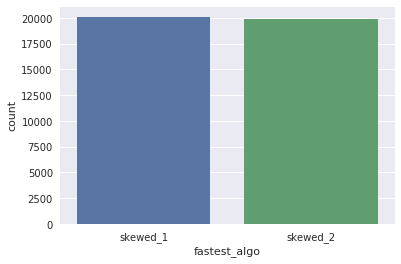

In [29]:
sns.set(color_codes=True)
sns.countplot(x="fastest_algo", data=test_dataset)

In [30]:
calculateValueOfML(train_benchmarkSet, test_benchmarkSet)

Average classification precision: 0.45
Total ml time: 10542880
Total old school time: 365085854
Machine learning is faster by : 33.63
With perfect prediction : 59.30


/home/jeremie/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Serialize model

In [31]:
# from sklearn.externals import joblib

# clf = DecisionTreeClassifier(max_depth=None, random_state=0)
# clf.fit(X, cy)
# joblib.dump(clf, '.joblib')

In [32]:
math.log(2500, 2)

11.287712379549449